In [1]:
import train
import coco_dataset
import transforms as T

main_folder_path = "../"
model_name = "tf_efficientdet_d0"
target_dim = 512
num_classes, train_df, test_df, categories_df = train.process_data_coco(main_folder_path, None)

dataset = coco_dataset.COCODataset(train_df, True, model_name, main_folder_path, target_dim, num_classes,
                                        T.get_transform(train=True), False)
dataset_test = coco_dataset.COCODataset(test_df, False, model_name, main_folder_path, target_dim, num_classes,
                                             T.get_transform(train=True), False)

Running on non Google Colab env
loading annotations into memory...
Done (t=11.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Num of classes is [90]
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercatego

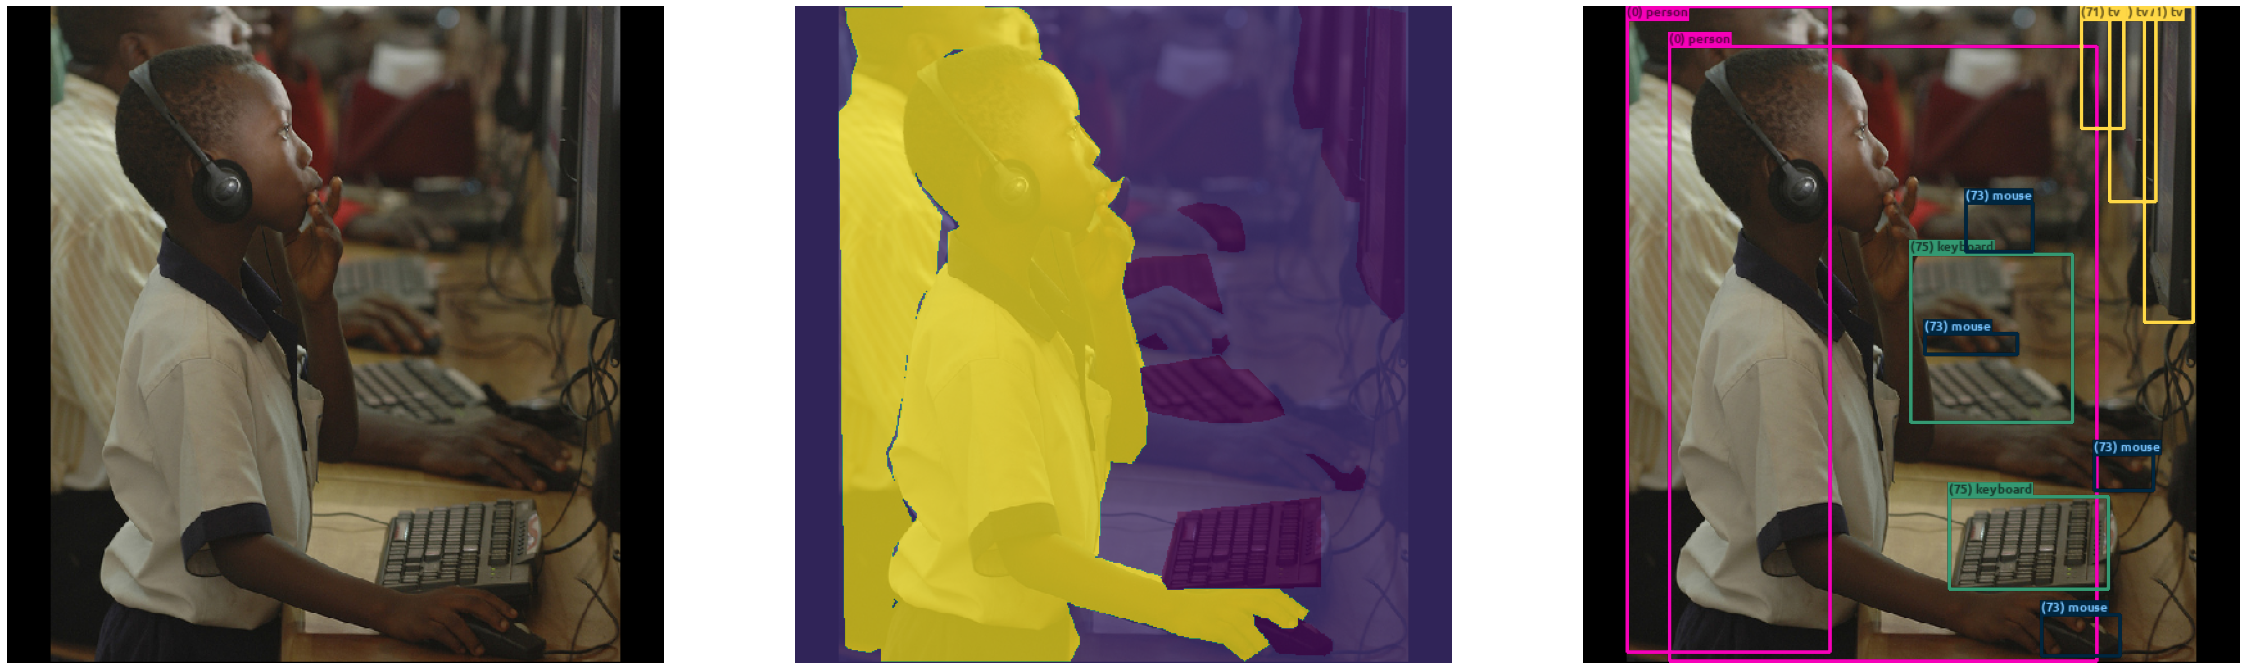

In [3]:
import visualize
vis = visualize.Visualize(main_folder_path, categories_df, target_dim, dest_folder=None)
import torch

def show_image_data_ground_truth(dataset, idx, is_colab, figsize=(40, 40)):
    image, target = dataset.__getitem__(idx)
    vis.show_image_data(image, torch.sub(target['labels'], 1), target['masks'], target['boxes'], figsize=figsize)
    
show_image_data_ground_truth(dataset, 3, False)